
--- Nearest Word Table: Pet Sematary ---


,Word,Neighbor_1,Neighbor_2,Neighbor_3
0,wrenching,loosening,loosen,tools
1,music,musical,melody,singing
2,apples,apple,fruit,cocoa
3,telephone,telephones,phone,dial
4,startle,start,starting,starts
5,accumulating,accusatory,collecting,collected
6,hygienist,housekeeper,specialist,gynecologist
7,storage,storing,stored,memory
8,angled,angle,angles,slant
9,bedpan,dustpan,bed,beds



--- Nearest Word Table: The Shining ---


,Word,Neighbor_1,Neighbor_2,Neighbor_3
0,ordinarily,blearily,preternaturally,eerily
1,durkin,dud,durin,harking
2,howie,josh,matt,ryan
3,mystery,mysterious,puzzled,peculiar
4,sequined,sequins,jockeyed,burlesquing
5,raking,rake,raddled,rabble
6,pens,pen,ink,pent
7,seem,seems,seemed,appears
8,buggin,bugle,bugged,bug
9,opinions,opinion,thoughts,subjectively


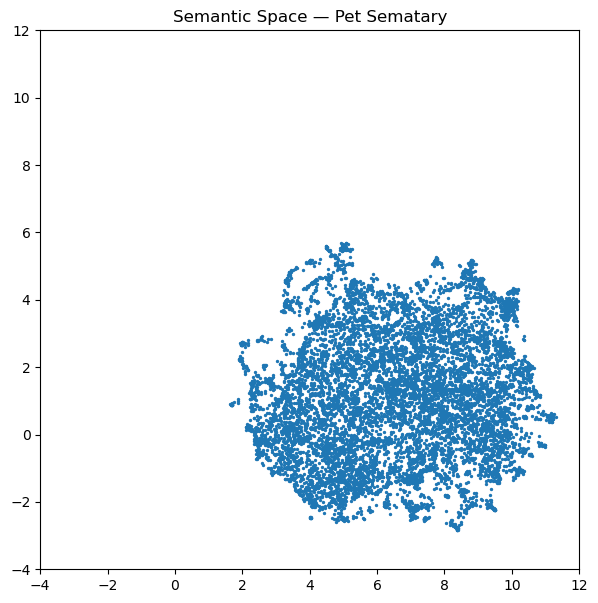

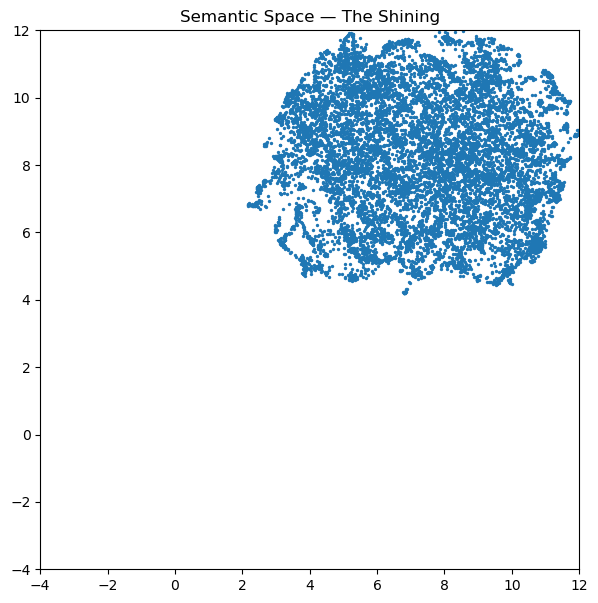

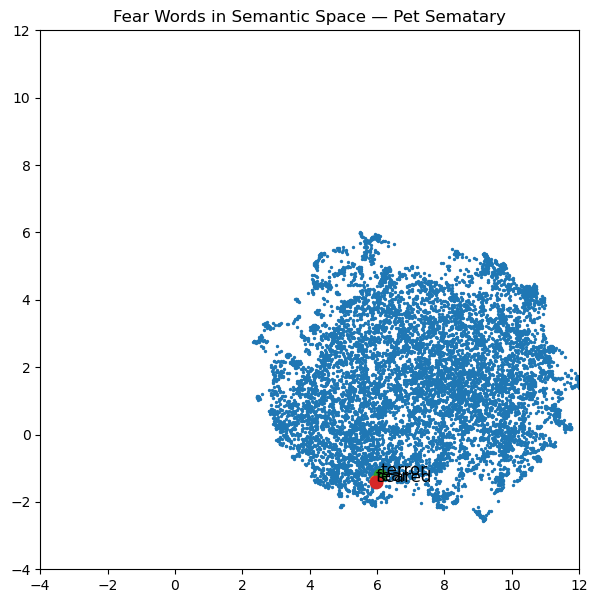

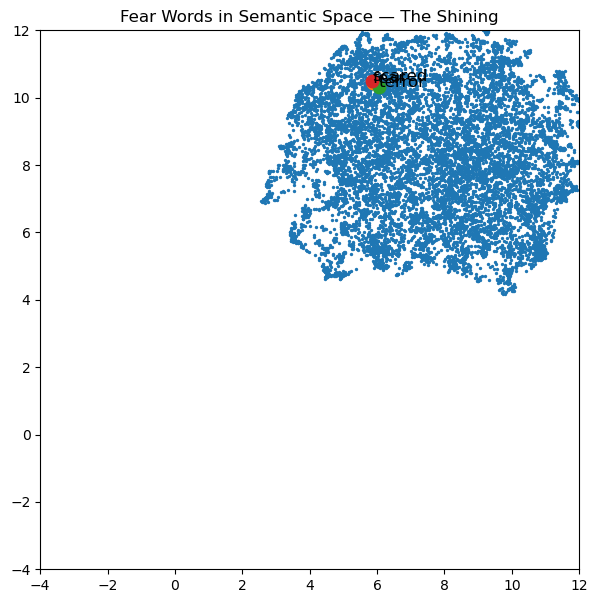

In [3]:
import re

# ---------------------------
# Load books
# ---------------------------

def load_book(path):
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

pet = load_book(r"C:\Users\dhima\Documents\NLP\NPL_Project\the_books\PetSematary_updated.txt")
shine = load_book(r"C:\Users\dhima\Documents\NLP\NPL_Project\the_books\TheShining_updated.txt")

books = {
    "Pet Sematary": pet,
    "The Shining": shine
}

# ---------------------------
# Extract vocabulary
# ---------------------------

def get_vocab(text, min_len=3):
    tokens = re.findall(r"\b[a-zA-Z]{%d,}\b" % min_len, text.lower())
    return sorted(set(tokens))

vocab = {title: get_vocab(text) for title, text in books.items()}

len(vocab["Pet Sematary"]), len(vocab["The Shining"])
# ---------------------------
# Embedding model
# ---------------------------

from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer("all-MiniLM-L6-v2")
# ---------------------------
# Compute embeddings
# ---------------------------

embeddings = {
    title: model.encode(vocab_list)
    for title, vocab_list in vocab.items()
}

embeddings["Pet Sematary"].shape, embeddings["The Shining"].shape
# ---------------------------
# Nearest neighbors for fear words
# ---------------------------

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

fear_words = ["fear", "terror", "scared"]

def get_neighbors(word, vocab_list, emb_matrix, top_k=10):
    if word not in vocab_list:
        return None
    idx = vocab_list.index(word)
    sims = cosine_similarity([emb_matrix[idx]], emb_matrix)[0]
    top_idx = sims.argsort()[::-1][1:top_k+1]
    return [(vocab_list[i], sims[i]) for i in top_idx]

neighbors = {
    title: {fw: get_neighbors(fw, vocab[title], embeddings[title]) for fw in fear_words}
    for title in books
}

neighbors
# ---------------------------
# Nearest words table (20 random words, 5 neighbors each)
# ---------------------------

import pandas as pd

def get_random_sample(vocab_list, n=20, seed=42):
    np.random.seed(seed)
    return list(np.random.choice(vocab_list, size=n, replace=False))

def nearest_words_table(vocab_list, emb_matrix, num_words=20, k=3):
    sample_words = get_random_sample(vocab_list, n=num_words)
    vectors = np.array([emb_matrix[vocab_list.index(w)] for w in sample_words])

    sim_matrix = cosine_similarity(vectors, emb_matrix)

    rows = []
    for i, w in enumerate(sample_words):
        sims = sim_matrix[i]
        idx_sorted = sims.argsort()[::-1]

        idx_sorted = [x for x in idx_sorted if vocab_list[x] != w]

        neighbors = [vocab_list[x] for x in idx_sorted[:k]]

        rows.append([w] + neighbors)

    columns = ["Word"] + [f"Neighbor_{i+1}" for i in range(k)]
    return pd.DataFrame(rows, columns=columns)

nearest_tables = {
    title: nearest_words_table(vocab_list=vocab[title], emb_matrix=embeddings[title])
    for title in books
}

print("\n--- Nearest Word Table: Pet Sematary ---")
display(nearest_tables["Pet Sematary"])

print("\n--- Nearest Word Table: The Shining ---")
display(nearest_tables["The Shining"])

# ---------------------------
# UMAP visualization
# ---------------------------

import umap
import matplotlib.pyplot as plt

for title in books:
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
    reduced = reducer.fit_transform(embeddings[title])

    plt.figure(figsize=(7,7))
    plt.scatter(reduced[:,0], reduced[:,1], s=2)

    
    plt.xlim(-4, 12)
    plt.ylim(-4, 12)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.title(f"Semantic Space — {title}")
    plt.show()
# ---------------------------
# Highlight fear words in UMAP
# ---------------------------

for title in books:
    vocab_list = vocab[title]
    emb = embeddings[title]

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
    reduced = reducer.fit_transform(emb)

    plt.figure(figsize=(7,7))
    plt.scatter(reduced[:,0], reduced[:,1], s=2)

    for fw in fear_words:
        if fw in vocab_list:
            idx = vocab_list.index(fw)
            plt.scatter(reduced[idx,0], reduced[idx,1], s=80)
            plt.text(reduced[idx,0], reduced[idx,1], fw, fontsize=12)

    # fixed axes to [-4, 12] and square
    plt.xlim(-4, 12)
    plt.ylim(-4, 12)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.title(f"Fear Words in Semantic Space — {title}")
    plt.show()